In [1]:
%matplotlib inline
from __future__ import division, print_function
import sys
import numpy as np
from astropy.table import Table, hstack
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from matplotlib.ticker import NullFormatter
from astropy import units as u
import fitsio
import pandas as pd
from astropy.coordinates import SkyCoord
import sys, os, time, argparse, glob
import matplotlib.patches as patches

import astropy.units
import healpy as hp

from desitarget.targetmask import desi_mask, bgs_mask
from main_def import cut_sweeps, cut, load_cat_caseA, load_cat_caseB, load_cat_caseC, load_cat_caseD, get_mag_decals, MASK, unextinct_fluxes, flux_to_mag, matrix_plot, bar_plot, venn_plot, target_con

### DECaLS DR7 catalogue
 
 This catalogue was taken from 'desitarget' at: /project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/targets-dr7.1-0.22.0.fits 
 
 For more info see email: [desi-bgs 1069] Official DR7 Target Release
 
..........

 To get BGS selection (non PSF and r < 20) using 'desitarget' use:
 
  mask &= ((cat0["DESI_TARGET"] & desi_mask["BGS_ANY"])!=0)
  
  To print columns names of fits file with fitsio.read(fits_file) use:
  
  dataframe.dtype.names

In [2]:
sweep_dir = os.path.join('/global/project/projectdirs/cosmo/data/legacysurvey/','dr7', 'sweep', '7.1')
catS = cut_sweeps(200, 230, -2,5, sweep_dir)

columns0 = ['RA', 'DEC', 'DESI_TARGET', 'BGS_TARGET']
catT = fitsio.read('targets-dr7.1-0.23.0.fits', columns=columns0, ext=1)
catT = cut(200, 230, -2,5, catT)

sweep-200m005-210p000 1688738
sweep-200p000-210p005 4086987
sweep-210m005-220p000 1739258
sweep-210p000-220p005 4353884
sweep-220m005-230p000 2276054
sweep-220p000-230p005 4815436
Bricks that matched: 6
Sample region # objects: 18960357


In [3]:
cat, catr, cat0, matrix_in, matrix_out, mask_list_MAG, dropped = load_cat_caseA(catS, catT, FILE=False, desitarget=True)

Lenght raw catalogue: 18960357


/global/project/projectdirs/desi/users/qmxp55/matches/main_def.py:695: RuntimeWarning: divide by zero encountered in log10
  Grr = gaiagmag - 22.5 + 2.5*np.log10(objects['FLUX_R'])
/global/project/projectdirs/desi/users/qmxp55/matches/main_def.py:695: RuntimeWarning: invalid value encountered in log10
  Grr = gaiagmag - 22.5 + 2.5*np.log10(objects['FLUX_R'])


Lenght DR7 sample within r <= 20: 1030591
Lenght DR7 sample after cuts 887231
adding desitarget and bgstarget column to catalogue...
catS: 18960357
catT: 1557493
Matching...
len idx: 1557493
d2d != 0 0
adding Grr column to catalogue...


In [10]:
def nobs_plot(cat0, NOBS, MAX):
    
    import matplotlib.patches as patches

    rfluxtmp =  cat0['FLUX_R']/cat0['MW_TRANSMISSION_R']
    #mask = flux_to_mag(rfluxtmp) <= 20
    mask = (cat0['NOBS_G']>=MAX) & (cat0['NOBS_R']>=MAX) & (cat0['NOBS_Z']>=MAX)
    cat0tmp = cat0[mask]
    print(len(cat0tmp))

    fig, ax = plt.subplots(figsize=(20,10))
    cax = ax.scatter(cat0tmp['RA'][::10], cat0tmp['DEC'][::10], c=cat0tmp[NOBS][::10], cmap=plt.cm.get_cmap('viridis'), s=0.1)
    rect = patches.Rectangle((200, -2),30,7,linewidth=1.5,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((211.5, -2),12,5,linewidth=1.5,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    ax.add_patch(rect2)
    ax.set_title('NOBS_R & NOBS_G & NOBS_Z>%i' %(MAX))
    ax.set_xlabel(r'RA')
    ax.set_ylabel(r'DEC')

    cbar = fig.colorbar(cax)
    cbar.set_label(NOBS)

    plt.show()

18945679


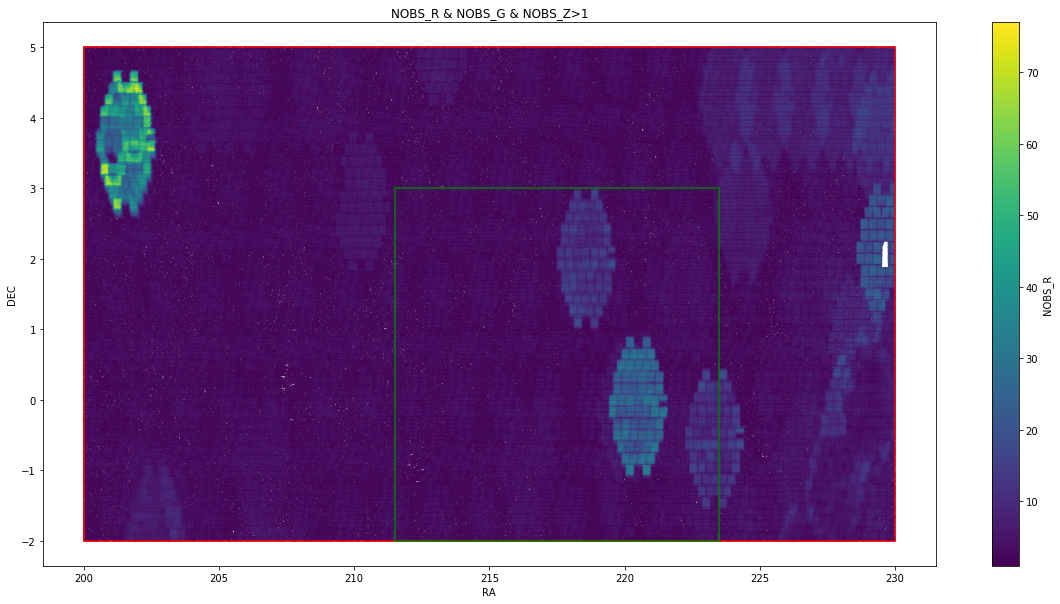

In [11]:
nobs_plot(cat0, 'NOBS_R', 1)

Cut catalogue to sample region:

200 $\leq$ RA $\leq$ 230

-2 $\leq$ DEC $\leq$ +5

In [18]:
def mag_hist_decals(df):
    
    print('Full:',len(df))
    #Remember to remove all fluxes <= 0 since the log(<=0)=inf.
    df = df[(df['FLUX_R'] > 0) & (df['FLUX_G'] > 0) & (df['FLUX_Z'] > 0)]
    print('FLUX_[R,G,Z]>=0:',len(df))
    
    rmag = flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
    
    print('r<=0:',len(df[df['FLUX_R'] <= 0]))
    print('g<=0:',len(df[df['FLUX_G'] <= 0]))
    print('z<=0:',len(df[df['FLUX_Z']<= 0]))
    
    mask_psf = df['TYPE'] == b'PSF '
    #mask_nopsf = df['TYPE'] != b'PSF '
    mask_rex = df['TYPE'] == b'REX '
    mask_dev = df['TYPE'] == b'DEV '
    mask_exp = df['TYPE'] == b'EXP '
    mask_comp = df['TYPE'] == b'COMP '
    bins = np.linspace(16, 27, 100)
    #test = np.array([np.isinf(rmag)])
    #print(np.sum(test))
    plt.figure(figsize=(12, 7))
    #plt.hist(zmag[(zmag < 27.5) & mask], 70, label=r'z')
    plt.hist(rmag[(mask_rex)], bins=bins,label=r'r, REX', alpha=0.7, histtype='step', fill=False)
    plt.hist(rmag[(mask_dev)], bins=bins,label=r'r, DEV', alpha=0.7, histtype='step', fill=False)
    plt.hist(rmag[(mask_exp)], bins=bins,label=r'r, EXP', alpha=0.7, histtype='step', fill=False)
    plt.hist(rmag[(mask_comp)], bins=bins,label=r'r, COMP', alpha=0.7, histtype='step', fill=False)
    plt.hist(rmag[(mask_psf)], bins=bins,label=r'r, PSF', alpha=0.7, histtype='step', fill=False)
    plt.hist(rmag, bins=bins,label=r'r, All', alpha=1, histtype='step', fill=False)
    #plt.hist(gmag[(gmag < 27.5) & mask], 70,label=r'g', alpha=0.6)
    plt.xlim(16, 27)
    #plt.ylim(0, 1e5)
    plt.legend()
    plt.grid()

Full: 18960357
FLUX_[R,G,Z]>=0: 17775320
r<=0: 0
g<=0: 0
z<=0: 0


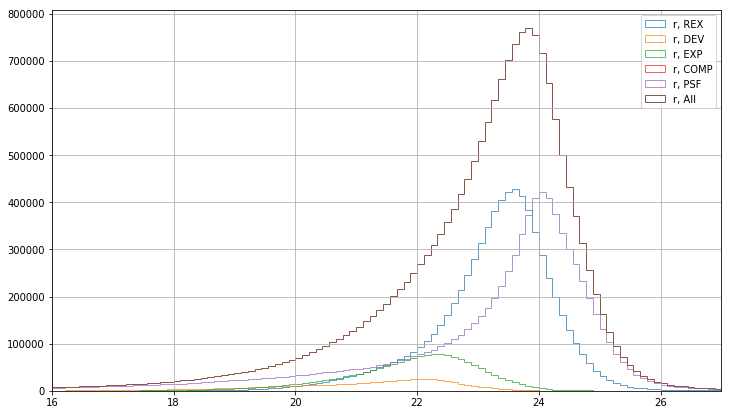

In [19]:
mag_hist_decals(cat0)

In [16]:
def mag_hist_decals_2(df):
    
    print('Full:',len(df))
    #Remember to remove all fluxes <= 0 since the log(<=0)=inf.
    df = df[(df['FLUX_R'] > 0) & (df['FLUX_G'] > 0) & (df['FLUX_Z'] > 0)]
    print('FLUX_[R,G,Z]>=0:',len(df))
    plt.figure(figsize=(12, 8))
    
    for i in range(1,8):
        
        mask = (df['NOBS_G']==i) & (df['NOBS_R']==i) & (df['NOBS_Z']==i)
        #mask = df['NOBS_R']==i
        cat0tmp = df[mask]
        print(i, len(cat0tmp))
        rmag = flux_to_mag(cat0tmp['FLUX_R']/cat0tmp['MW_TRANSMISSION_R'])
    #gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
    #zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
    #test = np.array([np.isinf(rmag)])
    #print(np.sum(test))
    #plt.hist(zmag[zmag < 27.5], 70, label=r'z')
        plt.hist(rmag[rmag < 27.5], 70,label=r'r, NOBS=%g'%(i), alpha=0.7)
    #plt.hist(gmag[gmag < 27.5], 70,label=r'g', alpha=0.6)
        plt.xlim(12, 24)
        plt.legend()
        plt.grid()
        plt.yscale('log')
        
    plt.show()

Full: 18960357
FLUX_[R,G,Z]>=0: 17775320
1 45489
2 932416
3 2450394
4 1278387
5 174916
6 38203
7 17462


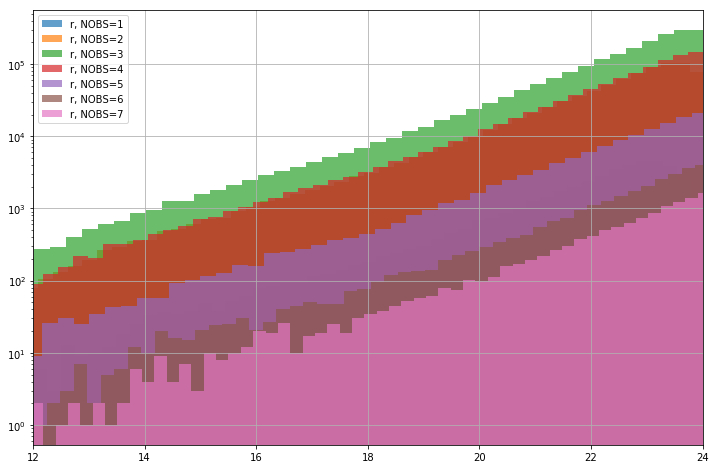

In [17]:
mag_hist_decals_2(cat0)

### GAMA DR3 catalogue
Loading GAMA TilingCat.fits from http://www.gama-survey.org/dr3/schema/table.php?id=3
The Petro mags and model mags come with extinction correction for SDSS DR7.

In [20]:
#Load GAMA TilingCat.fits with astropy Table
gama = Table.read('TilingCat.fits')

In [21]:
#Selecting the G15 field by RA and DEC
gamaS = cut(211.5, 223.5, -2,3, gama)

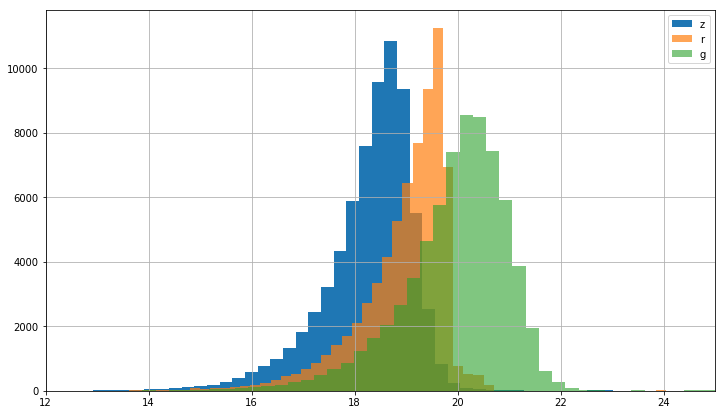

In [22]:
plt.figure(figsize=(12, 7))
plt.hist(gamaS['Z_MODEL'], 70, label=r'z')
plt.hist(gamaS['R_MODEL'], 70,label=r'r', alpha=0.7)
plt.hist(gamaS['G_MODEL'], 70,label=r'g', alpha=0.6)
plt.xlim(12, 25)
plt.legend()
plt.grid()

### SDSS DR14 catalogue

##### SQL query
For this sample we use the following  query:

    SELECT TOP 500000
       p.objid,p.ra,p.dec,p.type,p.insideMask, p.flags, p.flags_r,
    p.modelMag_u, p.modelMag_g, p.modelMag_r, p.modelMag_i, p.modelMag_z,
    p.petroMag_u, p.petroMag_g, p.petroMag_r, p.petroMag_i, p.petroMag_z,
    p.extinction_u, p.extinction_g, p.extinction_r, p.extinction_i, p.extinction_z
    FROM Galaxy AS p
    WHERE 
        p.ra >= 200 and p.ra <= 230
        AND (p.dec >= -2 and p.dec <= 5)
        AND (p.modelMag_r > 0 and p.modelMag_r <= 20)
        AND ((p.flags_r & 0x10000000) != 0) 
        -- detected in BINNED1 
        AND ((p.flags_r & 0x8100000c00a0) = 0) 
        -- not NOPROFILE, PEAKCENTER, NOTCHECKED, PSF_FLUX_INTERP, SATURATED, 
        -- or BAD_COUNTS_ERROR. 
        -- if you want to accept objects with interpolation problems for PSF mags, 
        -- change this to: AND ((flags_r & 0x800a0) = 0) 
        AND (((p.flags_r & 0x400000000000) = 0) or (p.psfmagerr_r <= 0.2)) 
        -- not DEBLEND_NOPEAK or small PSF error 
        -- (substitute psfmagerr in other band as appropriate) 
        AND (((p.flags_r & 0x100000000000) = 0) or (p.flags_r & 0x1000) = 0) 
        -- not INTERP_CENTER or not COSMIC_RAY - omit this AND clause if you want to 
        -- accept objects with interpolation problems for PSF mags. "
      
     ----- 
    import astroquery
    from astroquery.sdss import SDSS
    query = "SELECT TOP 500000 p.objid,p.ra,p.dec,p.type,p.insideMask, p.flags, p.flags_r, p.modelMag_u, p.modelMag_g, p.modelMag_r, p.modelMag_i, p.modelMag_z, p.petroMag_u, p.petroMag_g, p.petroMag_r, p.petroMag_i, p.petroMag_z, p.extinction_u, p.extinction_g, p.extinction_r, p.extinction_i, p.extinction_z FROM Galaxy AS p WHERE p.ra >= 200 and p.ra <= 230 AND (p.dec >= -2 and p.dec <= 5) AND (p.modelMag_r > 0 and p.modelMag_r <= 20) AND ((p.flags_r & 0x10000000) != 0) AND ((p.flags_r & 0x8100000c00a0) = 0) AND (((p.flags_r & 0x400000000000) = 0) or (p.psfmagerr_r <= 0.2)) AND (((p.flags_r & 0x100000000000) = 0) or (p.flags_r & 0x1000) = 0) "
    res = SDSS.query_sql(query)
    print(len(res))
    -----

In [23]:
!ls sdss_photo/photo_sdss_14_STA*

sdss_photo/photo_sdss_14_STAR_rmag_0_19.5.fits
sdss_photo/photo_sdss_14_STAR_rmag_19.5_21.fits
sdss_photo/photo_sdss_14_STAR_rmag_21_22.fits
sdss_photo/photo_sdss_14_STAR_rmag_22.5_max.fits
sdss_photo/photo_sdss_14_STAR_rmag_22_22.5.fits


In [4]:
def conca_sdss():
    cat_gal_1 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_0_20.fits')
    cat_gal_2 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_20_21.fits')
    cat_gal_3 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_21_21.5.fits')
    cat_gal_4 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_21.5_21.8.fits')
    cat_gal_5 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_21.8_22.2.fits')
    cat_gal_6 = fitsio.read('sdss_photo/photo_sdss_14_GAL_rmag_22.2_max.fits')
    
    cat_star_1 = fitsio.read('sdss_photo/photo_sdss_14_STAR_rmag_0_19.5.fits')
    cat_star_2 = fitsio.read('sdss_photo/photo_sdss_14_STAR_rmag_19.5_21.fits')
    cat_star_3 = fitsio.read('sdss_photo/photo_sdss_14_STAR_rmag_21_22.fits')
    cat_star_4 = fitsio.read('sdss_photo/photo_sdss_14_STAR_rmag_22.5_max.fits')
    cat_star_5 = fitsio.read('sdss_photo/photo_sdss_14_STAR_rmag_22_22.5.fits')
                             
    cat_gal = np.concatenate((cat_gal_1, cat_gal_2, cat_gal_3, cat_gal_4, cat_gal_5, cat_gal_6))
    cat_star = np.concatenate((cat_star_1, cat_star_2, cat_star_3, cat_star_4, cat_star_5))
    
    #remove objects with flux_[r,g,z] < 0 as we did in DECaLS
    cat_gal = cat_gal[(cat_gal['modelMag_z'] > 0) & (cat_gal['modelMag_r'] > 0) & (cat_gal['modelMag_g'] > 0)]
    cat_star = cat_star[(cat_star['modelMag_z'] > 0) & (cat_star['modelMag_r'] > 0) & (cat_star['modelMag_g'] > 0)]
    
    cat = np.concatenate((cat_gal, cat_star))
    
    print('SDSS #GAL:',len(cat_gal))
    print('SDSS #STAR:',len(cat_star))
    print('SDSS #TOTAL:',len(cat))
    
    return cat, cat_gal, cat_star

In [5]:
sdss, sdss_gal, sdss_star = conca_sdss()

SDSS #GAL: 2310433
SDSS #STAR: 1908553
SDSS #TOTAL: 4218986


In [26]:
def mag_hist_sdss(df):
    
    rmag = df['modelMag_r']-df['extinction_r']
    gmag = df['modelMag_g']-df['extinction_g']
    zmag = df['modelMag_z']-df['extinction_z']
    rmagS = np.logical_and(rmag > 12, rmag < 26)
    gmagS = np.logical_and(gmag > 12, gmag < 26)
    zmagS = np.logical_and(zmag > 12, zmag < 26)
    #test = np.array([np.isinf(rmag)])
    #print(np.sum(test))
    plt.figure(figsize=(12, 7))
    plt.hist(zmag[zmagS], 50, label=r'z')
    plt.hist(rmag[rmagS], 50, label=r'r', alpha=0.7)
    plt.hist(gmag[gmagS], 50, label=r'g', alpha=0.6)
    plt.xlim(12, 26)
    plt.legend()
    plt.grid()

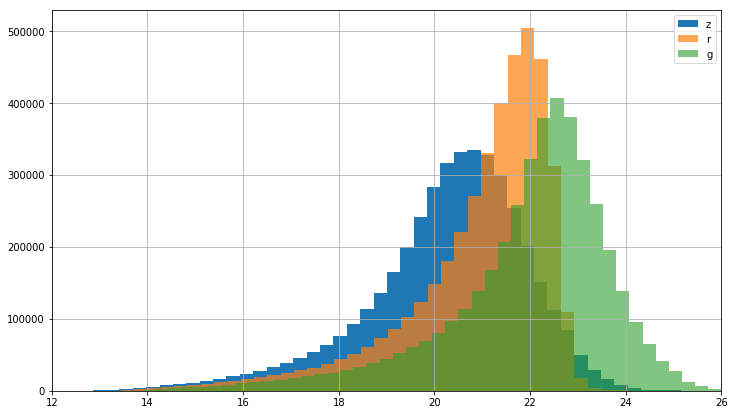

In [27]:
mag_hist_sdss(sdss)

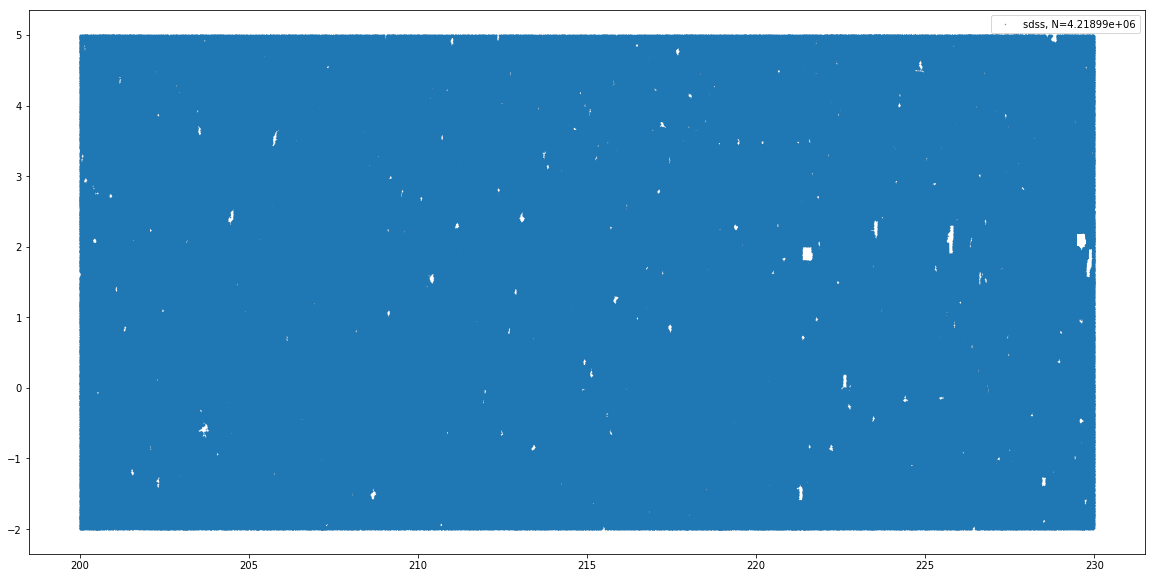

In [28]:
plt.figure(figsize=(20, 10))
#plt.plot(catS['RA'], catS['DEC'], '.', markersize=0.5, alpha=1, label = 'decals, N=%g'%(len(catS)))
plt.plot(sdss['ra'], sdss['dec'], '.', markersize=0.9, alpha=0.8, label = 'sdss, N=%g'%(len(sdss)))
#plt.plot(gamaS['RA'], gamaS['DEC'], '.', markersize=0.8, alpha=0.7, label = 'gama, N=%g'%(len(gamaS)))

plt.legend()
plt.show()

In [39]:
def gr_rz_plot(df):
    
    rmag = df['modelMag_r']-df['extinction_r']
    gmag = df['modelMag_g']-df['extinction_g']
    zmag = df['modelMag_z']-df['extinction_z']
    MASK = rmag < 20
    
    plt.figure(figsize=(10, 10))
    
    plt.scatter(gmag[MASK]-rmag[MASK], rmag[MASK]-zmag[MASK], s=0.01, label=r'SDSS galaxies #%d' %(len(gmag[MASK])))
    
    plt.xlabel(r'g-r')
    plt.ylabel(r'r-z')
    plt.xlim(-1, 2.8)
    plt.ylim(-1.5, 3)
    lgnd = plt.legend()
    for handle in lgnd.legendHandles:
        handle.set_sizes([14.0])

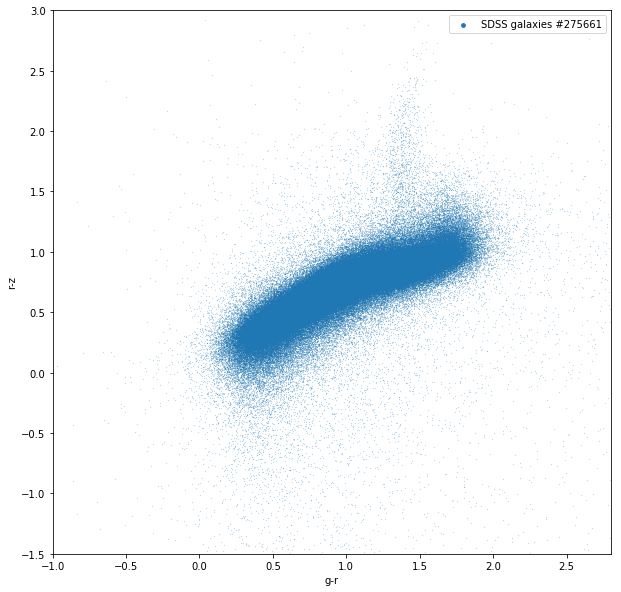

In [42]:
gr_rz_plot(sdss_gal)

#### Matching SDSS with DECaLS sample with r < 20

For SDSS:

    * sdss['type'] == 3 ----> GALAXIES
    * sdss['type'] == 6 ----> STARS

In [6]:
def match(cat1, cat2):
    
    print('cat1:', len(cat1))
    print('cat2:', len(cat2))
    
    raS = np.array(cat1['RA'])
    decS = np.array(cat1['DEC'])
    
    raT = np.array(cat2['ra'])
    decT = np.array(cat2['dec'])

    # Matching catalogs
    print("Matching...")
    skycatS = SkyCoord(raS*u.degree,decS*u.degree, frame='icrs')
    skycatT = SkyCoord(raT*u.degree,decT*u.degree, frame='icrs')
    idx1, d2d1, _1 = skycatT.match_to_catalog_sky(skycatS)
    idx2, d2d2, _2 = skycatS.match_to_catalog_sky(skycatT)
    print('len idx1:%d, idx2:%d' %(len(idx1[idx1 > 0]), len(idx2[idx2 > 0])))
    #print('d2d != 0',len(d2d[d2d != 0]))
        # For each object in catT, a closest match to catS is found. Thus not all catS objects are included. 
        # idx is the catS index for catT -- idx[0] is the catS index that the first catT object matched.
        # Similarly d2d is the distance between the matches. 
    
    #desitarget = np.zeros(len(catS))
    #bgstarget = np.zeros(len(catS))
    #catT_ra = np.zeros(len(catS))
    #catT_dec = np.zeros(len(catS))
    #mask = d2d != 0
    #idx = idx[mask]
    #desitarget[idx] = catT['DESI_TARGET']
    #bgstarget[idx] = catT['BGS_TARGET']
    #catT_ra[idx] = catT['RA']
    #catT_dec[idx] = catT['DEC']
    
    #for i in idx:
    #    diff_dec = abs(catS['DEC'][i] - catT_dec[i])
    #    diff_ra = abs(catS['RA'][i] - catT_ra[i])
    #    print('diff_dec > 0.001',len(diff_dec[diff_dec > 0.001]))
    #    print('diff_ra > 0.001',len(diff_ra[diff_ra > 0.001]))

    return idx1, idx2, d2d1, d2d2

In [7]:
idx1, idx2, d2d1, d2d2 = match(catr, sdss)

cat1: 1030591
cat2: 4218986
Matching...
len idx1:4218979, idx2:1030590


In [8]:
match = hstack([Table(catr), Table(sdss[idx2])])
match['d2d_arcsec'] = d2d2.arcsec

In [9]:
def scatter_match(match, N):
    
    plt.figure(figsize=(18, 9))
    match_d2d = match[match['d2d_arcsec'] < N]
    plt.plot(match_d2d['RA'], match_d2d['DEC'], '.', markersize=10, alpha=1, label=r'DECaLS')
    plt.plot(match_d2d['ra'], match_d2d['dec'], '.', markersize=5, alpha=1, label=r'SDSS')
    plt.title(r'%d Matched objects for d2d < %2.2f arcsec' %(len(match_d2d),N))
    plt.legend()
    plt.xlim(205, 205.5)
    plt.ylim(2,2.5)


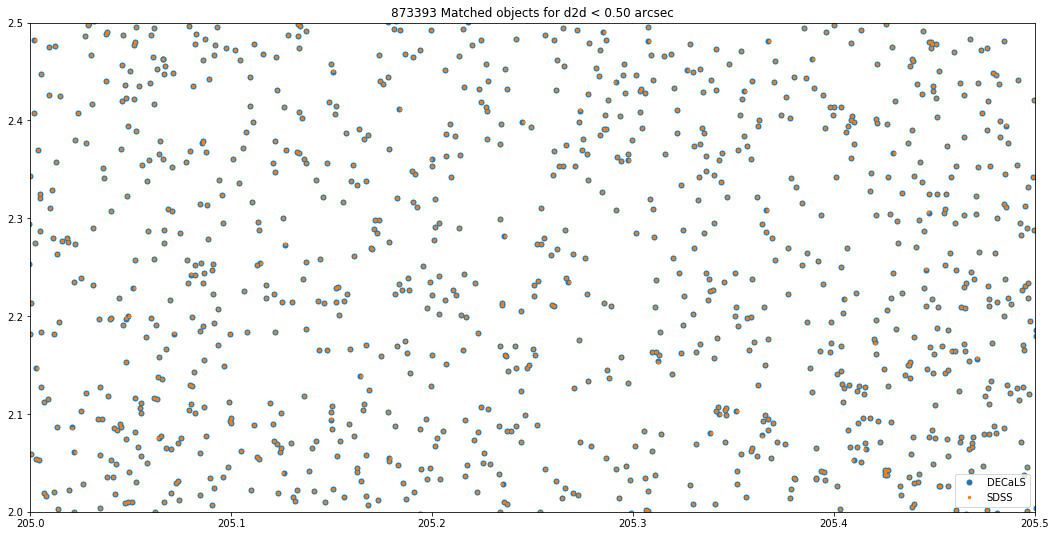

In [106]:
scatter_match(match, 0.5)

In [107]:
match['type'][0]

3

In [10]:
def quality_match(match, N, col, vline):
    
    #plt.figure(figsize=(12, 6))
    #match = match[match['d2d_arcsec'] < N]
    #match = match[(match['d2d_arcsec'] < N) & (match[col] < 10) & (match[col] > -5)] #For FRACFLUX
    match = match[(match['d2d_arcsec'] < N) & (match[col] < 1.2)] #For FRACMASKED < 1.2
    g, r, z, w1, G, rr = get_mag_decals(match)
    SDSS_GAL = match['type'] == 3
    SDSS_STAR = match['type'] == 6
    
    
    f, axarr = plt.subplots(3, sharex=True, figsize=(14, 14))
    
    axarr[0].scatter(match[col][SDSS_STAR], g[SDSS_STAR]-r[SDSS_STAR], s=0.1, label=r'SDSS_STAR = %d' %(len(r[SDSS_STAR])))
    axarr[0].scatter(match[col][SDSS_GAL], g[SDSS_GAL]-r[SDSS_GAL], s=0.1, label=r'SDSS_GAL = %d' %(len(r[SDSS_GAL])))
    axarr[0].axvline(x=vline)
    axarr[0].axhline(y=-1)
    axarr[0].axhline(y=4)
    
    axarr[1].scatter(match[col][SDSS_STAR], r[SDSS_STAR]-z[SDSS_STAR], s=0.1, label=r'SDSS_STAR = %d' %(len(r[SDSS_STAR])))
    axarr[1].scatter(match[col][SDSS_GAL], r[SDSS_GAL]-z[SDSS_GAL], s=0.1, label=r'SDSS_GAL = %d' %(len(r[SDSS_GAL])))
    axarr[1].axvline(x=vline)
    axarr[1].axhline(y=-1)
    axarr[1].axhline(y=4)
    
    axarr[2].scatter(match[col][SDSS_STAR], g[SDSS_STAR]-z[SDSS_STAR], s=0.1, label=r'SDSS_STAR = %d' %(len(r[SDSS_STAR])))
    axarr[2].scatter(match[col][SDSS_GAL], g[SDSS_GAL]-z[SDSS_GAL], s=0.1, label=r'SDSS_GAL = %d' %(len(r[SDSS_GAL])))
    axarr[2].axvline(x=vline)
    
    axarr[2].set_xlabel(col)
    axarr[0].set_ylabel('g-r')
    axarr[1].set_ylabel('r-z')
    axarr[2].set_ylabel('g-z')
    #axarr[0].set_xlim(-3,7)
    lgnd = plt.legend()
    for handle in lgnd.legendHandles:
        handle.set_sizes([14.0])
    
    plt.show()
    

/global/project/projectdirs/desi/users/qmxp55/matches/main_def.py:213: RuntimeWarning: divide by zero encountered in log10
  mag = 22.5 - 2.5*np.log10(flux)
/global/project/projectdirs/desi/users/qmxp55/matches/main_def.py:213: RuntimeWarning: invalid value encountered in log10
  mag = 22.5 - 2.5*np.log10(flux)
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in subtract
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in subtract


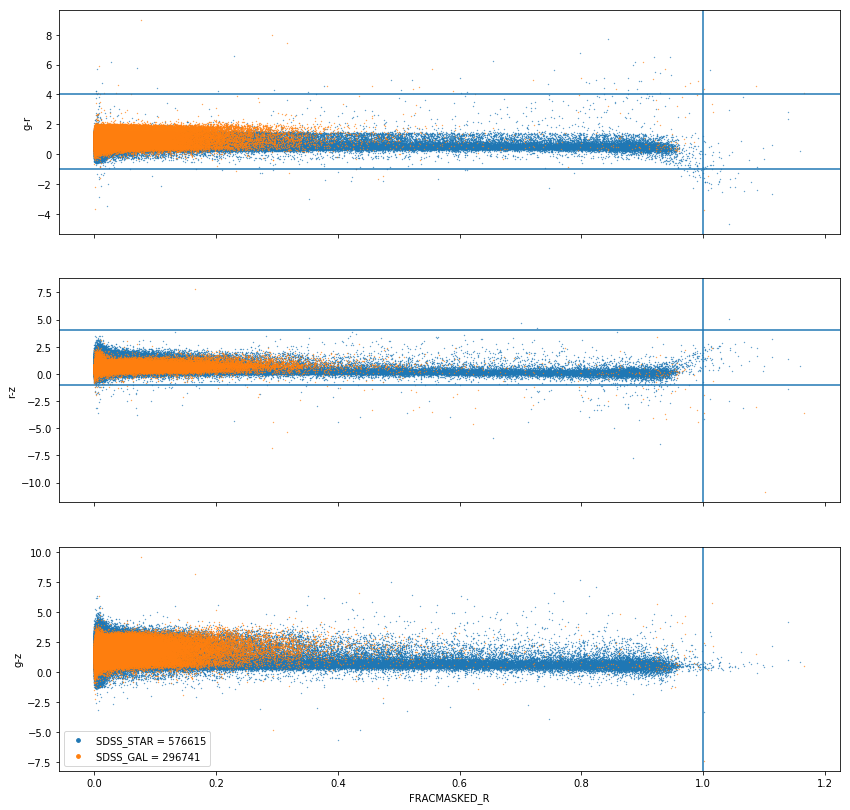

In [11]:
quality_match(match, 0.5, 'FRACMASKED_R', 1)

In [183]:
def quality_Grr(match, N, col, vline):
    
    plt.figure(figsize=(15, 7))
    match = match[(match['d2d_arcsec'] < N) & (match[col] > -3)] #Only for Grr
    #match = match[(match['d2d_arcsec'] < N) & (match[col] < 2)]
    #g, r, z, w1, G, rr = get_mag_decals(match)
    SDSS_GAL = match['type'] == 3
    SDSS_STAR = match['type'] == 6
    file = []
    grr = np.linspace(match[col].min(), match[col].max(), 40)
    
    for i in range(len(grr)):
        
        MASK = match[col] < grr[i]
        NGAL = len(match[(SDSS_GAL) & (MASK)])
        NSTAR = len(match[(SDSS_STAR) & (MASK)])
        file.append([grr[i], 100*NGAL/np.sum(SDSS_GAL), 100*NSTAR/np.sum(SDSS_STAR)])
    
    file = np.array(file).transpose()
    
    plt.plot(file[0], file[1], marker='o', label=r'SDSS GAL -- tot=%d' %(np.sum(SDSS_GAL)))
    plt.plot(file[0], file[2], marker='o', label=r'SDSS STAR -- tot=%d' %(np.sum(SDSS_STAR)))
    plt.axvline(x=vline)
    
    plt.xlabel(col)
    plt.ylabel(r'%')
    plt.legend()
    plt.show()
    
    #plt.figure(figsize=(15, 7))
    #plt.scatter(g-z, match['Grr'], s=0.1)
    #plt.show()
    
    return file

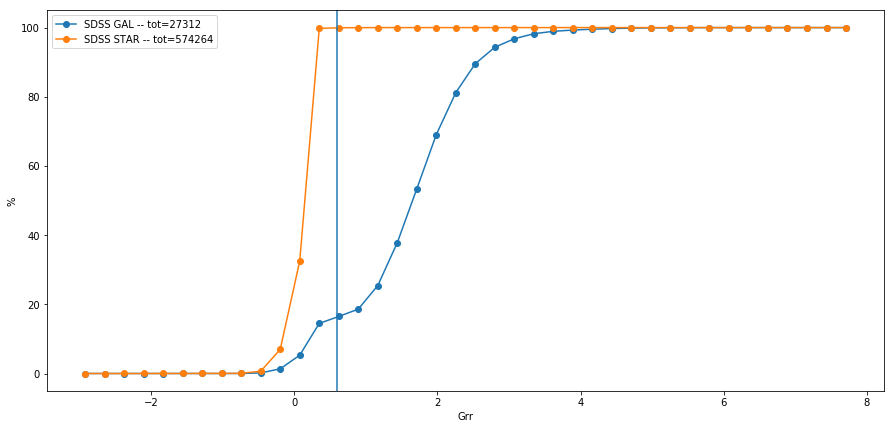

In [186]:
file = quality_Grr(match, 0.5, 'Grr', 0.6)

## RANDOMS

In [70]:
randoms = fitsio.read('/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/randoms-dr7.1-0.22.0.fits')

In [78]:
ran0S = cut(200, 230, -2,5, randoms)
ranS = ran0S[(ran0S['NOBS_G']>=3) & (ran0S['NOBS_R']>=3) & (ran0S['NOBS_Z']>=3)]
print('#ran0S:', len(ran0S))
print('#ranS:', len(ranS))

20972586
#ran0S: 20972586
#ranS: 14449927


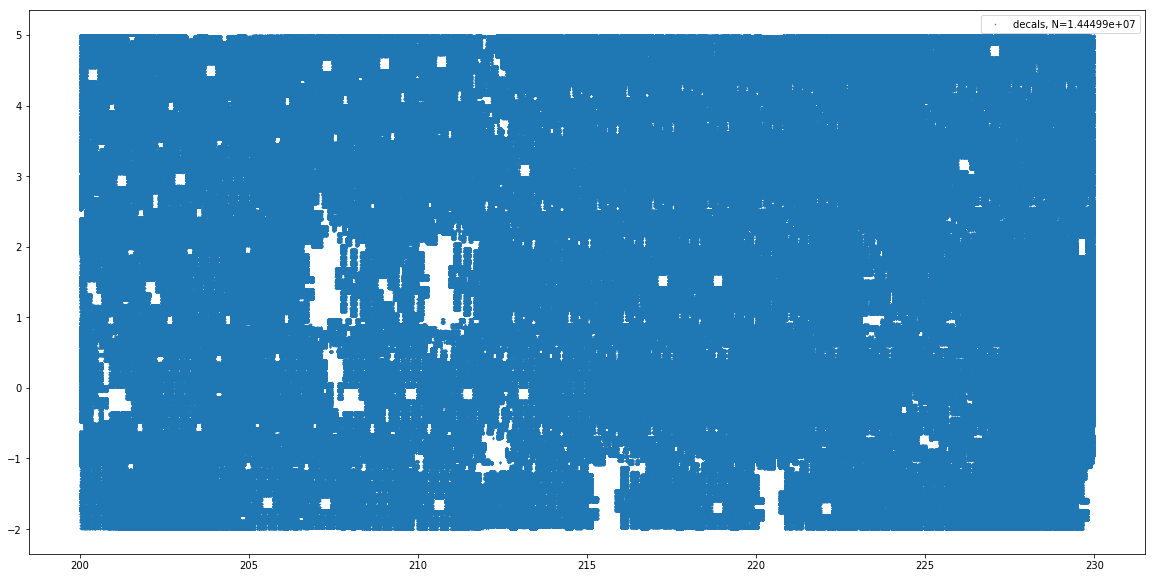

In [205]:
plt.figure(figsize=(20, 10))
plt.plot(ranS['RA'], ranS['DEC'], '.', markersize=1, alpha=1, label = 'decals, N=%g'%(len(ranS)))

plt.legend()
plt.show()

In [84]:
#pixw = fitsio.read('/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/pixweight-dr7.1-0.22.0.fits')

In [237]:
def pixmap(RA, DEC, N):
    #theta = 0.5 * np.pi - np.deg2rad(dec)
    #phi = np.deg2rad(ra)
    #N = 512
    m = hp.ang2pix(N, RA, DEC, nest=False, lonlat=True)

    def gen_fast_map(ip_, nside=N):
        npixel  = hp.nside2npix(nside)
        print(npixel)
        map_ = np.bincount(ip_,minlength=npixel)
        return map_

    map = gen_fast_map(m)
    hp.cartview(map, lonra=[200 - 360, 230 - 360], latra=[-2,5])
    #hp.cartview(map)

3145728


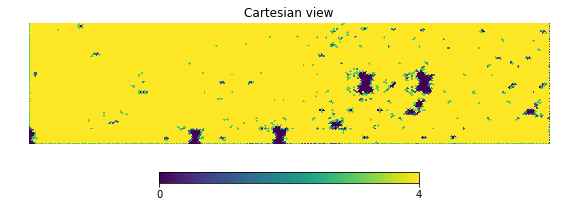

In [238]:
pixmap(ra, dec, 256*2)

3145728


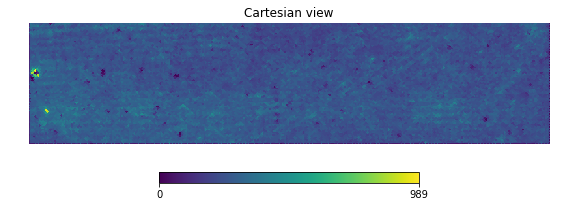

In [224]:
pixmap(sdss['ra'], sdss['dec'], 256*2)

## DEV zone

In [ ]:
#theta = 0.5 * np.pi - np.deg2rad(dec)
#phi = np.deg2rad(ra)
N = 512
m = hp.ang2pix(N, ra, dec, nest=False, lonlat=True)

def gen_fast_map(ip_, nside=N):
    npixel  = hp.nside2npix(nside)
    print(npixel)
    map_ = np.bincount(ip_,minlength=npixel)
    return map_

map = gen_fast_map(m)
hp.cartview(map, lonra=[200 - 360, 230 - 360], latra=[-2,5])
#hp.cartview(map)

In [ ]:
from skymapper import skymapper as skm

# load RA/Dec from catalog [not implemented]
ra, dec = ranS['RA'], ranS['DEC']

# get count in healpix cells (as vertices), restrict to non-empty cells
nside = 1024
bc, ra, dec, vertices = skm.getCountAtLocations(ra, dec, nside=nside, return_vertices=True)

# setup figure
import matplotlib.cm as cm
cmap = cm.YlOrRd
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111, aspect='equal')

# setup map: define AEA map optimal for given RA/Dec
proj = skm.createConicMap(ax, ra, dec, proj_class=skm.AlbersEqualAreaProjection)
# add lines and labels for meridians/parallels (separation 5 deg)
sep = 5
meridians = np.arange(-90, 90+sep, sep)
parallels = np.arange(0, 360+sep, sep)
skm.setMeridianPatches(ax, proj, meridians, linestyle='-', lw=0.5, alpha=0.3, zorder=2)
skm.setParallelPatches(ax, proj, parallels, linestyle='-', lw=0.5, alpha=0.3, zorder=2)
skm.setMeridianLabels(ax, proj, meridians, loc="left", fmt=skm.pmDegFormatter)
skm.setParallelLabels(ax, proj, parallels, loc="bottom")

# add vertices as polygons
vmin, vmax = np.percentile(bc,[10,90])
poly = skm.addPolygons(vertices, proj, ax, color=bc, vmin=vmin, vmax=vmax, cmap=cmap, zorder=3, rasterized=True)

# add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.0)
cb = fig.colorbar(poly, cax=cax)
cb.set_label('$n_g$ [arcmin$^{-2}$]')
cb.solids.set_edgecolor("face")

# show (and save) ...
fig.tight_layout()
fig.show()
#fig.savefig(imagefile)

In [8]:
#del test_c
    
test_c = np.empty(len(gama), dtype='S3')
j = 0
for word in gama['SPECID']:
    if word.startswith('G15'):
        test_c[j] = str(word[:3])
        #print(j, str(word[:3]))
    
    j = j + 1
    
#del gama['new']
#del gama['G15']

gama['field'] = test_c

In [30]:
gama_g15 = gama[gama['field'] == b'G15']
gama_g15 = gama_g15.to_pandas()
gama_p = gama.to_pandas()

In [38]:
gama_p['SURVEY'].value_counts()
#clean = gama.replace('NULL', nan)
#clean = gama.dropna()
#clean[gama['SURVEY']].value_counts()

GAMA         133494
SDSS          23228
2dFGRS         2075
MGC             664
6dFGS           171
2QZ             157
WiggleZ          87
VVDS             66
2SLAQ-QSO        32
2SLAQ-LRG        27
GAMA_LT          15
UZC               6
NED               4
Name: SURVEY, dtype: int64

In [52]:
decals_sdss = Table.read('decals-dr7.0-sdss-specObj-dr14-unique-trimmed-match.fits')

In [41]:
sdss = Table.read('specObj-dr14.fits')

In [43]:
mask = np.logical_and(sdss['PLUG_RA'] <= gama_g15['RA'].max(), sdss['PLUG_RA'] >= gama_g15['RA'].min())  
mask &= np.logical_and(sdss['PLUG_DEC'] <= gama_g15['DEC'].max(), sdss['PLUG_DEC'] >= gama_g15['DEC'].min())
sdss_g15 = sdss[mask]

In [46]:
sdss_short = Table.read('sdss-specObj-dr14-unique-trimmed.fits')

In [55]:
decals_gama = Table.read('decals-dr7.0-GAMA-DR3-SpecObj-match.fits')

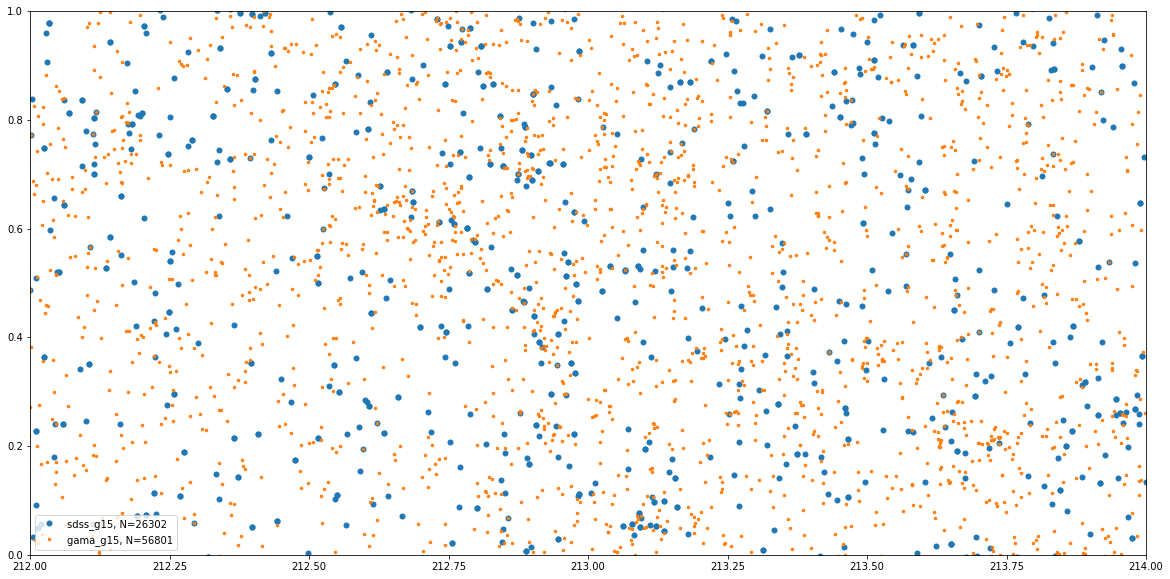

In [51]:
plt.figure(figsize=(20, 10))
plt.plot(sdss_g15['PLUG_RA'], sdss_g15['PLUG_DEC'], 'o', markersize=5, alpha=1, label = 'sdss_g15, N=%g'%(len(sdss_g15)))
plt.plot(gama_g15['RA'], gama_g15['DEC'], '.', markersize=5, alpha=1, label = 'gama_g15, N=%g'%(len(gama_g15)))
plt.axis([212, 214, 0, 1])
plt.legend()
plt.show()

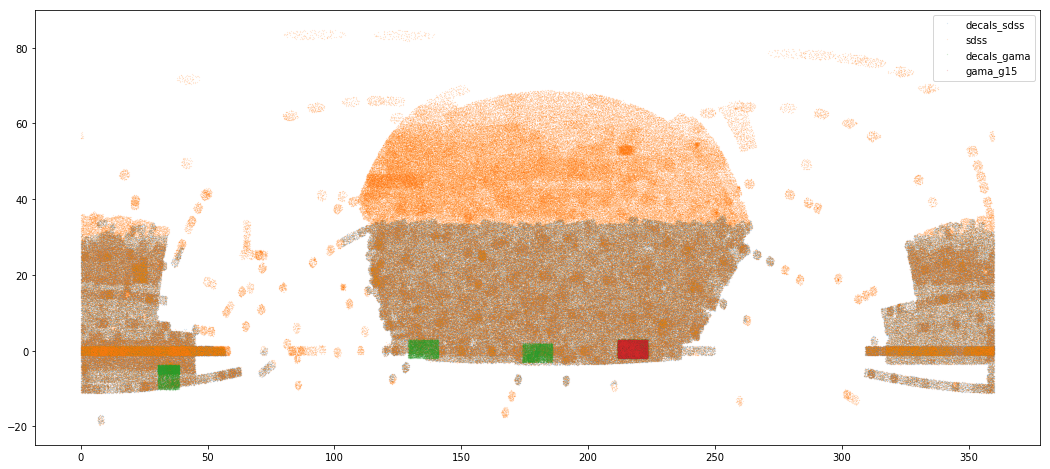

In [222]:
plt.figure(figsize=(18, 8))
plt.plot(decals_sdss['RA'][::10], decals_sdss['DEC'][::10], '.', markersize=0.4, alpha=0.3, label = 'decals_sdss')
plt.plot(sdss_short['PLUG_RA'][::10], sdss_short['PLUG_DEC'][::10], '.', markersize=0.4, alpha=0.3, label = 'sdss')
plt.plot(decals_gama['RA'][::10], decals_gama['DEC'][::10], '.', markersize=0.4, alpha=0.4, label = 'decals_gama')
plt.plot(gama_g15['RA'][::10], gama_g15['DEC'][::10], '.', markersize=0.4, alpha=0.4, label = 'gama_g15')
#plt.axis([0, 360, -23, 35])
plt.legend()
plt.show()